In [53]:
#meta 10/9/2020 myStudy Ch5. Image Classification (multilabel)

In [3]:
#hide
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

In [4]:
#hide
from fastbook import *

# Image Classification

## From Dogs and Cats to Pet Breeds

In [5]:
print(URLs.PETS)

https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz


In [6]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [7]:
#path
#path #Path('/home/jupyter/.fastai/data/oxford-iiit-pet')
Path.BASE_PATH = path

Files organization: individual files representing items of data, images and annotations, organized into folders.

In [8]:
#see what's in our dataset -> 2 directories
path.ls()

(#2) [Path('images'),Path('annotations')]

The [website](https://www.robots.ox.ac.uk/~vgg/data/pets/) for the dataset tells us that the *annotations* directory contains information about where the pets are rather than what they are. In this chapter, we will be doing classification, not localization, which is to say that we care about what the pets are, not where they are. Therefore, we will ignore the *annotations* directory for now. So, let's have a look inside the *images* directory:

In [9]:
(path/"images").ls() #class fastcore.foundation.L

(#7393) [Path('images/Birman_142.jpg'),Path('images/american_pit_bull_terrier_49.jpg'),Path('images/pomeranian_188.jpg'),Path('images/Siamese_234.jpg'),Path('images/scottish_terrier_165.jpg'),Path('images/Persian_9.jpg'),Path('images/Birman_78.jpg'),Path('images/keeshond_12.jpg'),Path('images/Siamese_21.jpg'),Path('images/japanese_chin_164.jpg')...]

In [10]:
fname = (path/"images").ls()[0]
fname

Path('images/Birman_142.jpg')

In [11]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Birman']

In [12]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

In [13]:
pets.__class__, dls.__class__

(fastai.data.block.DataBlock, fastai.data.core.DataLoaders)

## Presizing

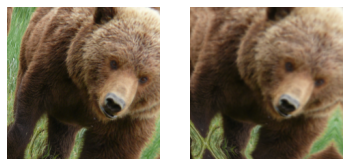

In [14]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

### Checking and Debugging a DataBlock

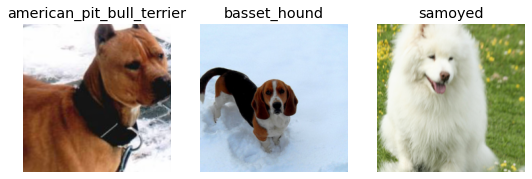

In [15]:
dls.show_batch(nrows=1, ncols=3)

In [16]:
#demo of a mistake -> forgot to include resise method 
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/jupyter/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_37.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=334x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/jupyter/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_37.jpg
    applying partial gives
      wheaten_terrier
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(35)

Final sample: (PILImage mode=RGB size=334x500, TensorCategory(35))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}

Bui

RuntimeError: stack expects each tensor to be equal size, but got [3, 500, 334] at entry 0 and [3, 380, 500] at entry 1

In [17]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.495896,0.362787,0.108931,00:48


epoch,train_loss,valid_loss,error_rate,time
0,0.516180,0.331450,0.100135,00:54
1,0.325271,0.242890,0.076455,00:55


## Cross-Entropy Loss
$acConcept

### Viewing Activations and Labels

In [18]:
x,y = dls.one_batch()

In [19]:
y

TensorCategory([30, 26, 20, 19, 15,  5,  3, 12, 33, 24, 29, 23, 18, 27, 20, 20, 31, 18, 25, 11, 18, 23,  8, 17,  3, 33, 35, 27, 22, 21, 18, 16, 35, 35, 27, 27, 18, 19, 18, 28, 29, 32, 30, 11, 11, 14, 34, 12,
         2,  5, 28, 28,  5,  8, 11, 15, 14, 28,  1, 23, 14,  1, 13, 36], device='cuda:0')

In [20]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([1.6504e-08, 1.7567e-06, 1.3079e-05, 3.2803e-07, 1.4657e-07, 3.3294e-06, 2.4904e-06, 5.5533e-07, 7.0816e-07, 3.9117e-08, 1.1183e-07, 1.1230e-06, 7.2173e-04, 2.5692e-05, 6.7870e-05, 2.3845e-05,
        1.1414e-05, 7.3452e-08, 3.3905e-06, 2.6537e-04, 4.0019e-06, 1.0208e-05, 1.2779e-05, 1.4999e-05, 2.6037e-07, 3.4848e-05, 2.4378e-08, 3.5673e-05, 4.0087e-08, 4.7969e-07, 9.9874e-01, 1.5114e-06,
        1.3448e-06, 5.4673e-07, 8.2137e-07, 1.0119e-06, 4.4288e-07])

In [21]:
len(preds[0]),preds[0].sum()

(37, tensor(1.))

### Softmax

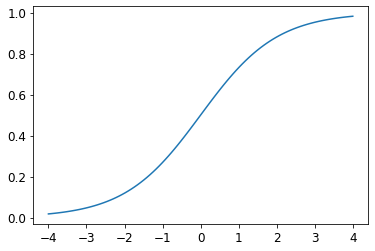

In [22]:
plot_function(torch.sigmoid, min=-4,max=4)

In [23]:
#hide
torch.random.manual_seed(42);

In [24]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [25]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [26]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [27]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Log Likelihood

In [28]:
targ = tensor([0,1,0,1,1,0])

In [29]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [30]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [31]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,loss
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


In [32]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [33]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

### Taking the Log

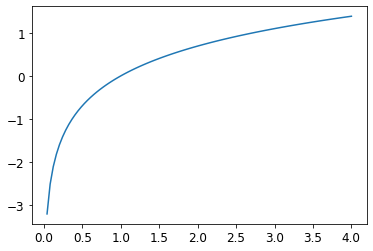

In [34]:
plot_function(torch.log, min=0,max=4)

In [35]:
loss_func = nn.CrossEntropyLoss()

In [36]:
loss_func(acts, targ)

tensor(1.8045)

In [37]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [38]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Model Interpretation

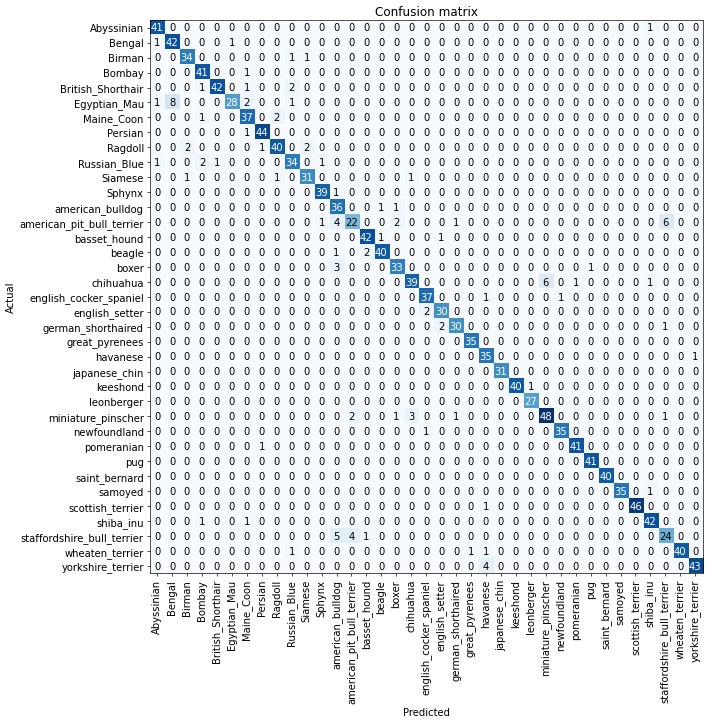

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [40]:
interp.most_confused(min_val=5)

[('Egyptian_Mau', 'Bengal', 8),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('chihuahua', 'miniature_pinscher', 6),
 ('staffordshire_bull_terrier', 'american_bulldog', 5)]

## Improving Our Model

### The Learning Rate Finder

In [41]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.732736,6.089869,0.514208,00:41


epoch,train_loss,valid_loss,error_rate,time
0,3.495840,2.008310,0.570365,00:54


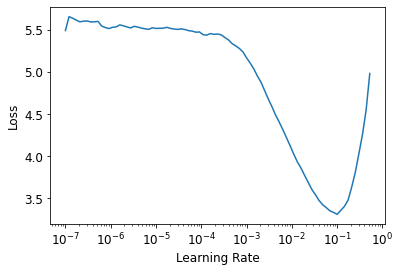

In [42]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [43]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 2.09e-03


In [44]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.309351,0.332609,0.109608,00:41


epoch,train_loss,valid_loss,error_rate,time
0,0.573408,0.327484,0.104871,00:55
1,0.321488,0.221956,0.073072,00:55


### Unfreezing and Transfer Learning

In [45]:
learn.fine_tune??

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
)
Source:   
@patch
@log_args(but_as=Learner.fit)
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `freeze` for `freeze_epochs` then with `unfreeze` from `epochs` using discriminative LR"
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      /opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py
Type:      method


In [46]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.107483,0.296592,0.100812,00:41
1,0.534837,0.255099,0.086604,00:41
2,0.320525,0.212701,0.070365,00:41


In [47]:
learn.unfreeze()

SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=1.9054607491852948e-06)

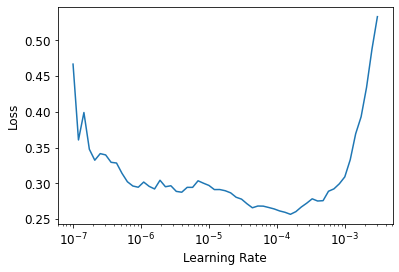

In [48]:
learn.lr_find()

In [49]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.244343,0.213264,0.072395,00:55
1,0.244432,0.201014,0.063599,00:55
2,0.228357,0.201431,0.068336,00:55
3,0.230142,0.199328,0.065629,00:54
4,0.206878,0.192144,0.065629,00:55
5,0.186916,0.195811,0.064276,00:54


### Discriminative Learning Rates

In [50]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.161961,0.348711,0.106901,00:41
1,0.502035,0.263740,0.086604,00:41
2,0.312404,0.224792,0.069012,00:41


epoch,train_loss,valid_loss,error_rate,time
0,0.230576,0.223818,0.066306,00:55
1,0.256171,0.216617,0.071042,00:54
2,0.224292,0.205385,0.069012,00:55
3,0.204160,0.199641,0.068336,00:54
4,0.193490,0.196240,0.066306,00:54
5,0.168738,0.192922,0.062923,00:54
6,0.140288,0.198748,0.064276,00:54
7,0.134294,0.193848,0.062246,00:54
8,0.126831,0.186981,0.064953,00:54
9,0.122163,0.180453,0.060893,00:55


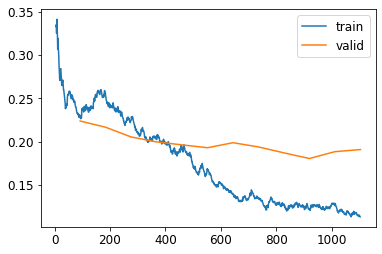

In [51]:
learn.recorder.plot_loss()

### Selecting the Number of Epochs

### Deeper Architectures

In [52]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jupyter/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.403331,0.297475,0.095399,00:36
1,0.596853,0.301058,0.094723,00:37
2,0.437359,0.266361,0.087280,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.259777,0.237850,0.075101,00:43
1,0.314221,0.310780,0.087280,00:43
2,0.271898,0.240296,0.072395,00:43
3,0.156437,0.211770,0.063599,00:43
4,0.088777,0.195455,0.054127,00:43
5,0.056568,0.189801,0.056834,00:43


## Conclusion

## Questionnaire

1. Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?
1. If you are not familiar with regular expressions, find a regular expression tutorial, and some problem sets, and complete them. Have a look on the book's website for suggestions.
1. What are the two ways in which data is most commonly provided, for most deep learning datasets?
1. Look up the documentation for `L` and try using a few of the new methods is that it adds.
1. Look up the documentation for the Python `pathlib` module and try using a few methods of the `Path` class.
1. Give two examples of ways that image transformations can degrade the quality of the data.
1. What method does fastai provide to view the data in a `DataLoaders`?
1. What method does fastai provide to help you debug a `DataBlock`?
1. Should you hold off on training a model until you have thoroughly cleaned your data?
1. What are the two pieces that are combined into cross-entropy loss in PyTorch?
1. What are the two properties of activations that softmax ensures? Why is this important?
1. When might you want your activations to not have these two properties?
1. Calculate the `exp` and `softmax` columns of <<bear_softmax>> yourself (i.e., in a spreadsheet, with a calculator, or in a notebook).
1. Why can't we use `torch.where` to create a loss function for datasets where our label can have more than two categories?
1. What is the value of log(-2)? Why?
1. What are two good rules of thumb for picking a learning rate from the learning rate finder?
1. What two steps does the `fine_tune` method do?
1. In Jupyter Notebook, how do you get the source code for a method or function?
1. What are discriminative learning rates?
1. How is a Python `slice` object interpreted when passed as a learning rate to fastai?
1. Why is early stopping a poor choice when using 1cycle training?
1. What is the difference between `resnet50` and `resnet101`?
1. What does `to_fp16` do?

### Further Research

1. Find the paper by Leslie Smith that introduced the learning rate finder, and read it.
1. See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve? Look on the forums and the book's website to see what other students have achieved with this dataset, and how they did it.